### Testing Evo

#### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *

#### Train the network

In [2]:
cluster_env = Cluster_Env(clusters=60, cluster_size=30)
centered_env = Centered_Env(food_amount=1000)
circle_env = Circle_Env(circles=4, food_amount=1000)
spiral_env = Spiral_Env(spirals=3, food_amount=1000)

In [3]:
train_config = Train_Config(stdev=0.05, popsize=40, 
    name='hidden6', problem_searcher=ProblemSearcher.GeneticAlgorithm)

In [4]:
generations = 200
name = 'hidden6'

#TODO make option for whether to run on samplepool or not

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 4,
    n = 10,
    #food_env=cluster_env,
    #food_env=centered_env,
    #food_env=circle_env,
    food_env=spiral_env,
    scale = 2,
    wrap_around = True,
    #model_type = ModelType.LocalOnly,
    model_type = ModelType.WithGlobalNode,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 3/4, 
    consumption_edge_required = 1,
    noise = 0.002,
    energy_required_to_replicate = 50,
    train_config=train_config,

    #only used if withGlobalNode
    #n2 = 
    radius_long_scale=2,
)

In [5]:
#TODO ADD settings like std of clusters..

trainer = Evo_Trainer(settings)
network = Conv(settings=settings)

2023-04-10 20:49:20,102	INFO worker.py:1528 -- Started a local Ray instance.


[2023-04-10 20:49:36] INFO     <67753> evotorch.core: Instance of `Custom_NEProblem` (id:11276538240) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-04-10 20:49:36] INFO     <67753> evotorch.core: Instance of `Custom_NEProblem` (id:11276538240) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-04-10 20:49:36] INFO     <67753> evotorch.core: Instance of `Custom_NEProblem` (id:11276538240) -- The `device` of the problem is set as cpu
[2023-04-10 20:49:36] INFO     <67753> evotorch.core: Instance of `Custom_NEProblem` (id:11276538240) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-04-10 20:49:36] INFO     <67753> evotorch.core: Instance of `Custom_NEProblem` (id:11276538240) -- Number of GPUs that will be allocated per actor is None


In [6]:
#trainer.train(10, 'temp')
#trainer.load_searcher() #load existing session

In [7]:
trainer.searcher.popsize = 10

In [8]:
generations=200

In [24]:
trainer.train(generations)

              iter : 201
  obj0_median_eval : -0.6917767524719238
    obj0_mean_eval : -3.106902599334717
obj0_pop_best_eval : 28.75600814819336
  obj1_median_eval : 6.0
    obj1_mean_eval : 6.493750095367432
obj1_pop_best_eval : 16.25
  obj2_median_eval : 0.0
    obj2_mean_eval : 0.125
obj2_pop_best_eval : 5.0
  obj3_median_eval : -6.909022331237793
    obj3_mean_eval : -9.725652694702148
obj3_pop_best_eval : 12.006007194519043

              iter : 202
  obj0_median_eval : -3.328902244567871
    obj0_mean_eval : -5.080906867980957
obj0_pop_best_eval : 27.430809020996094
  obj1_median_eval : 5.0
    obj1_mean_eval : 6.487500190734863
obj1_pop_best_eval : 14.75
  obj2_median_eval : 0.0
    obj2_mean_eval : 0.0
obj2_pop_best_eval : 0.0
  obj3_median_eval : -6.8621063232421875
    obj3_mean_eval : -11.56840705871582
obj3_pop_best_eval : 12.680808067321777

              iter : 203
  obj0_median_eval : 11.780749320983887
    obj0_mean_eval : 13.40233325958252
obj0_pop_best_eval : 29.96007

In [18]:
network = trainer.get_trained_network()

In [19]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [20]:
#trainer.searcher.status

#### Visualize trained network

In [21]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network(graph, 0)

DataBatch(x=[4044, 11], edge_index=[1, 0], device=[4], subsize=[4], velocity=[4], border_cost=[4], food_reward=[4], dead_cost=[4], visible_food=[4], food_avg_dist=[4], food_avg_degree=[4], food_search_movement=[4], batch=[4044], ptr=[5])

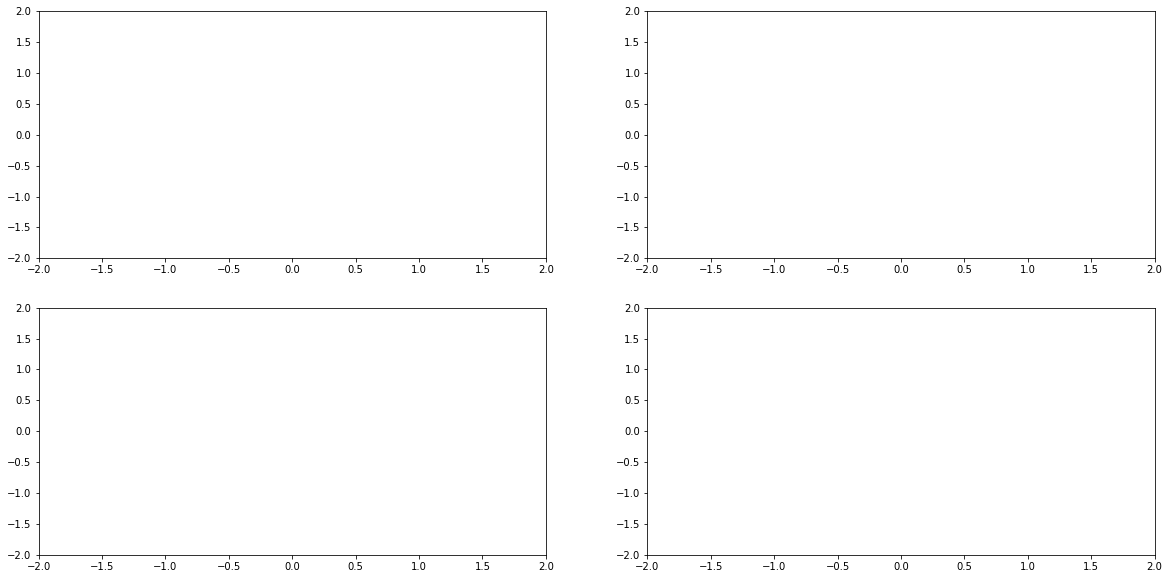

In [22]:
frames = 80 #test
#frames = 200 #visualize

#dpi = 200 #beautiful
dpi = 50 #fast

anim = visualizer.animate_organism(graph, network, food=30, frames=frames) 
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=dpi)

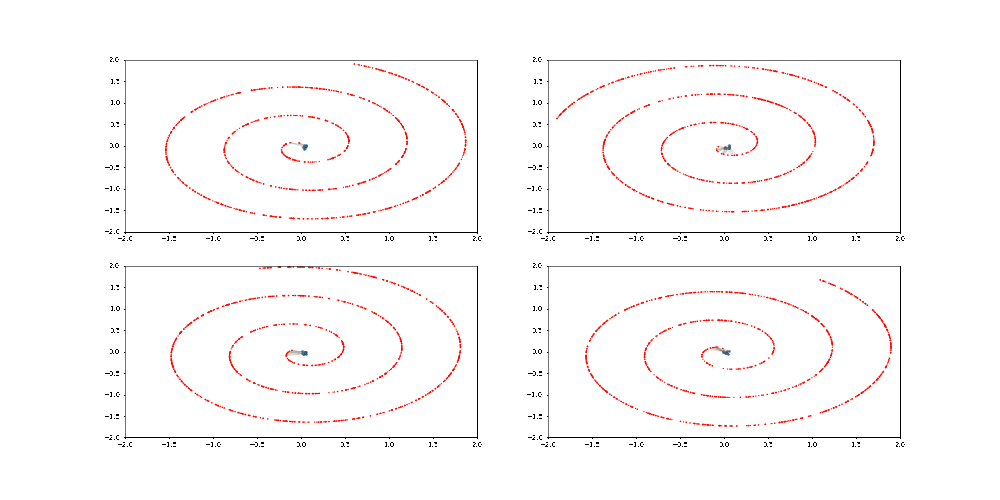

In [23]:
Image('../animation/' + name + '.gif')

In [16]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

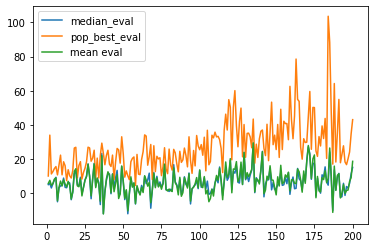

In [17]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

if settings.train_config.problem_searcher == ProblemSearcher.GeneticAlgorithm:
    plt.plot(losses.obj0_median_eval)
    plt.plot(losses.obj0_pop_best_eval)
    plt.plot(losses.obj0_mean_eval)
else:
    plt.plot(losses.median_eval)
    plt.plot(losses.pop_best_eval)
    plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()